In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import librosa as lb
import numpy as np
import sklearn
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pickle

In [ ]:
SONG_LENGTH = 430

In [ ]:
# SB_CNN implemented from this paper - https://arxiv.org/pdf/1608.04363.pdf
#import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv1D, MaxPool1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import itertools
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from keras import optimizers
#from src.config import *
#from src.explore import get_data

In [ ]:
def run_model(optimizer, n_iter):
    sbcnn = SBCNN_Model(field_size, bands, frames, num_channels, num_labels)

    sbcnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    print(sbcnn.summary)

    train_arr, train_labels_arr, test_arr, test_labels_arr = get_data()

    sbcnn.fit(train_arr, train_labels_arr, batch_size=32, nb_epoch=n_iter)

    y_prob = sbcnn.predict_proba(test_arr, verbose=0)
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(test_labels_arr, 1)
    roc = metrics.roc_auc_score(test_labels_arr, y_prob)

    print("SBCNN with optimizer {} and {} iterations".format(optimizer, n_iter))
    print("ROC:", round(roc, 3))

    score, accuracy = sbcnn.evaluate(test_arr, test_labels_arr, batch_size=32)
    print("\nOverall accuracy = {:.2f}".format(accuracy))

    print("Classwise accuracy - normalized")
    print(accuracy_score(y_true, y_pred))

    print("Classwise accuracy - unnormalized")
    print(accuracy_score(y_true, y_pred, normalize=True))

    print("Classification Report: {} optimizer, {} iterations".format(optimizer, n_iter))
    print(classification_report(y_true, y_pred, target_names=target_names))


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


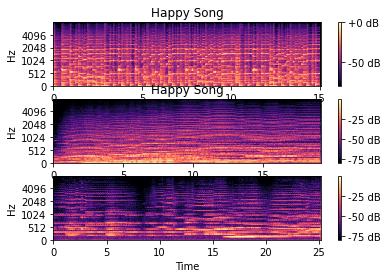

In [ ]:
# create mel-spectrogram
single_song_path = '/content/drive/MyDrive/Awaves Data/set1/mp3/Soundtrack360_mp3/'
y, sr = librosa.load(single_song_path + '001.mp3')
S = librosa.feature.melspectrogram(y=y, sr=sr)

fig, ax = plt.subplots(3)
S_dB = librosa.power_to_db(S, ref=np.max) #should I use powerToDB or AplitudeToDB ?
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[0])
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')



ax[0].set(title='Happy Song')

single_song_path = '/content/drive/MyDrive/Awaves Data/set1/mp3/Soundtrack360_mp3/'
y, sr = librosa.load(single_song_path + '031.mp3')
S = librosa.feature.melspectrogram(y=y, sr=sr)

S_dB = librosa.power_to_db(S, ref=np.max) #should I use powerToDB or AplitudeToDB ?
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1])
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

ax[1].set(title='Happy Song')


single_song_path = '/content/drive/MyDrive/Awaves Data/set1/mp3/Soundtrack360_mp3/'
y, sr = librosa.load(single_song_path + '032.mp3')
S = librosa.feature.melspectrogram(y=y, sr=sr)

S_dB = librosa.power_to_db(S, ref=np.max) #should I use powerToDB or AplitudeToDB ?
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[2])
fig.colorbar(img, ax=ax[2], format='%+2.0f dB')



In [ ]:
#audio_to_mfcc(single_song_path+'001.mp3').shape

In [ ]:
base_dir = '/content/drive/MyDrive/Awaves Data/set1/'

In [ ]:
def audio_to_spectogram(audio_file):
    y, sr = librosa.load(audio_file)
    y = y[:220500]
    S1 = librosa.feature.melspectrogram(y = y, sr = sr)


    power_to_db = librosa.power_to_db(S1, ref = np.max)
    return power_to_db[:, :430]



def divide_song_by_4(y, sr, X):
    y =  y[:55125], y[55125:110250], y[110250:165375], y[165375:220500]
    S1 = librosa.feature.melspectrogram(y = y[0], sr = sr)
    S2 = librosa.feature.melspectrogram(y = y[1], sr = sr)
    S3 = librosa.feature.melspectrogram(y = y[2], sr = sr)
    S4 = librosa.feature.melspectrogram(y = y[3], sr = sr)

    X.append(librosa.power_to_db(S1, ref = np.max))
    X.append(librosa.power_to_db(S2, ref = np.max))

    X.append(librosa.power_to_db(S3, ref = np.max))
    X.append(librosa.power_to_db(S4, ref = np.max))

    return X

def divide_song_by_2(y, sr, X):
    y =  y[:110250], y[110250:220500]
    S1 = librosa.feature.melspectrogram(y = y[0], sr = sr)
    S2 = librosa.feature.melspectrogram(y = y[1], sr = sr)

    X.append(librosa.power_to_db(S1, ref = np.max))

    X.append(librosa.power_to_db(S2, ref = np.max))

    return X

In [ ]:
def audio_to_mfcc(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    audio = audio[:220500] 
    #metric = librosa.feature.chroma_cens(y=audio, sr=sample_rate)


    S, phase = librosa.magphase(librosa.stft(audio))
    metric = librosa.amplitude_to_db(S, ref=np.max)
    


     
    return metric

In [ ]:
try:
    # Check if pickle file exists
    X = pickle.load(open("X.pickle", "rb"))
    X = np.asarray(X)
except (OSError, IOError) as e:

    # songs_path = f'{base_dir}mp3/Soundtrack360_mp3/'
    # dir = listdir(songs_path)
    # audio_files = [f for f in dir[:5] if isfile(join(songs_path, f))]
    # audio_files.sort()
    # X = []
    # for file in audio_files:
    #     X = audio_to_spectogram(songs_path+file, X)
    #
    # pickle.dump(X, open("X.pickle", "wb"))


    songs_path = f'{base_dir}mp3/Soundtrack360_mp3/'
    dir = listdir(songs_path)
    dir.sort()
    audio_files = [f for f in dir[:] if isfile(join(songs_path, f))]
    X = [audio_to_mfcc(songs_path + file) for file in audio_files] # This takes a shit load of time

    pickle.dump(X, open("X.pickle", "wb"))
    X = np.asarray(X)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
X.shape
# here 60 is the number of songs, and 40 is the number of MFCCs



(360, 1025, 431)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [ ]:


def SBCNN_1D():
    model = Sequential()

    #model.add(Conv1D(32, kernel_size=3, padding='same', activation = 'relu', input_shape=(128, SONG_LENGTH)))
    model.add(Conv1D(32, kernel_size=3, padding='same', activation = 'relu', input_shape=(X.shape[1], X.shape[2], 1)))
    model.add(MaxPool1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, padding='same', activation = 'relu'))
    model.add(MaxPool1D(pool_size=2))

    #model.add(Conv1D(64, kernel_size=5, padding='valid', activation = 'relu'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer=optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam',
                           #loss='sparse_categorical_crossentropy',
                           #metrics=['accuracy'])

    return model

In [ ]:


def SBCNN():  
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation = 'relu', input_shape=(X.shape[1], X.shape[2], 1)))
  model.add(MaxPool2D(pool_size=(3, 3)))
  model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size=(3, 3)))

  model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size=(3, 3)))

  model.add(Flatten())
  # model.add(Dropout(0.5))
  model.add(Dense(128, activation = 'relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(64, activation = 'relu'))
  # model.add(Dropout(0.5))

  model.add(Dense(32, activation = 'relu'))
  # model.add(Dropout(0.5))

  # model.add(Dense(2, activation = 'softmax', kernel_regularizer = l2(0.001)))
  # model.compile(optimizer=optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
  return model

In [ ]:


def SBCNN_regressesion():  
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', activation = 'relu', input_shape=(X.shape[1], X.shape[2], 1)))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001)))
  model.add(Dropout(0.5))

  model.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.001)))
  model.add(Dropout(0.5))

  # model.add(Dense(2, activation = 'softmax', kernel_regularizer = l2(0.001)))
  # model.compile(optimizer=optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 
  return model

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
target_path = f'{base_dir}mean_ratings_set1.xls'
#targets = pd.read_excel(target_path, usecols = ['happy', 'sad'])
#targets['result'] = targets['happy'] > targets['sad']
#targets = targets[:60]


targets = pd.read_excel(target_path, usecols = ['Number','energy'])
bins = [1,2,3,4,5,6,7]
labels = [1,2,3,4,5,6]
targets['binned'] = pd.cut(targets['energy'], bins = bins, labels = labels)

y = targets['binned'][:]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y=pd.get_dummies(y)

y

,1,2,3,4,5,6
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,1,0,0
...,...,...,...,...,...,...
355,0,1,0,0,0,0
356,0,1,0,0,0,0
357,0,1,0,0,0,0
358,0,0,0,1,0,0


In [ ]:
my_model = SBCNN()
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1025, 431, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 341, 143, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 341, 143, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 47, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 47, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 71040)             0

In [ ]:
def generate_data():

    for i in range(360):
      yield X[i], y[i]

In [ ]:
# generator = generate_data(X_train.shape[0])
# for i in generator:
#   print(i[1])

In [ ]:
X.shape

(360, 1025, 431, 1)

In [ ]:
y.shape

(360, 6)

In [ ]:
#my_model.fit(generate_data(), verbose=1, epochs=20)
my_model.fit(X, y, verbose=1, epochs=40)

Epoch 1/40
12/12 [==============================] - 39s 514ms/step - loss: 24.7342 - accuracy: 0.1799
Epoch 2/40
12/12 [==============================] - 5s 425ms/step - loss: 1.8598 - accuracy: 0.2073
Epoch 3/40
12/12 [==============================] - 5s 422ms/step - loss: 1.7284 - accuracy: 0.2801
Epoch 4/40
12/12 [==============================] - 5s 419ms/step - loss: 1.7090 - accuracy: 0.2537
Epoch 5/40
12/12 [==============================] - 5s 425ms/step - loss: 1.6622 - accuracy: 0.3170
Epoch 6/40
12/12 [==============================] - 5s 426ms/step - loss: 1.5886 - accuracy: 0.3756
Epoch 7/40
12/12 [==============================] - 5s 423ms/step - loss: 1.5387 - accuracy: 0.2982
Epoch 8/40
12/12 [==============================] - 5s 421ms/step - loss: 1.4679 - accuracy: 0.3292
Epoch 9/40
12/12 [==============================] - 5s 426ms/step - loss: 1.6186 - accuracy: 0.3282
Epoch 10/40
12/12 [==============================] - 5s 423ms/step - loss: 1.5298 - accuracy: 0.36

In [ ]:
import os
my_model.save(os.path.join(base_dir, "my_model.h5"))

In [ ]:
test_song = base_dir + "test_set/Chopin - Nocturne op.9 No.2.mp3"

test_song = base_dir + "test_set/Don't You Worry Child (Official Video).mp3"



audio, sample_rate = librosa.load(test_song)
# For song Dont you Worry Child
audio = audio[4740750:4961250]   #3:35 to 3:45 gives energy = 5

#audio = audio[6063750:6284250]   #4:35 to 4:45 gives energy = 4

# Chopin Song
#audio = audio[:220500]   




S, phase = librosa.magphase(librosa.stft(audio))
validate_x = librosa.amplitude_to_db(S, ref=np.max)
    



val_x = validate_x.reshape(1, validate_x.shape[0], validate_x.shape[1], 1)

op = my_model.predict(val_x)
np.argmax(op)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


5

In [ ]:
test_song = base_dir + "test_set/Swedish House Mafia ft. John Martin - Don't You Worry Child (Official Video).mp3"

#validate_x = audio_to_mfcc(test_song)

audio, sample_rate = librosa.load(test_song)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
audio.shape

(7386112,)

In [ ]:
sample_rate

22050